# Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install wandb
import wandb
import os
# os.environ['WANDB_API_KEY'] = <my key>

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


True

In [7]:
# Libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score


In [8]:
# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

In [9]:
%%capture
!pip install transformers

In [10]:
import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import Trainer, TrainingArguments
import numpy as np
import random
from sklearn.model_selection import train_test_split

# Data

In [11]:
# Data 
path_train = '/content/drive/MyDrive/DTU/Deep_Learning/FINAL_PROJECT/train.csv'
path_valid = '/content/drive/MyDrive/DTU/Deep_Learning/FINAL_PROJECT/valid.csv'
path_test = '/content/drive/MyDrive/DTU/Deep_Learning/FINAL_PROJECT/test.csv'

df_train = pd.read_csv(path_train)
df_valid = pd.read_csv(path_valid)
df_test= pd.read_csv(path_test)
df_train.head()

,is_sarcastic,headline,article_link,lenght
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,8
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,13
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,7
3,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,9
4,0,my white inheritance,https://www.huffingtonpost.com/entry/my-white-...,3


In [12]:
X_train = df_train['headline']
X_valid = df_valid['headline']
X_test = df_test['headline']

y_train = df_train['is_sarcastic']
y_valid = df_valid['is_sarcastic']
y_test = df_test['is_sarcastic']

In [13]:
target_names = list(df_train['is_sarcastic'].unique())
target_names

[1, 0]

In [14]:
X_train[0]

'thirtysomething scientists unveil doomsday clock of hair loss'

In [15]:
y_train.dtype

dtype('int64')

# Transformers
- Bert
- Distilled Bert

In [27]:
wandb.init(project="dtu_deepl_models", 
           entity="lucialarraona",
           name="bert-base-other-lr",
           tags=["baseline2", "default-lr", "3epoch", "test"],
           group="bert")


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▅█
train/global_step,▁▅█
train/learning_rate,▁█
train/loss,█▁
eval/accuracy,0.9141
eval/loss,0.23905


####  Define model and max_lenght

In [28]:
# Define model-name (based on hugging-face library)
model_name = "bert-base-uncased"
# max sequence length for each document/sentence sample (headlines are much shorter, we'll change it)
max_length = 200

#### Preprocessing

In [29]:
# Hugging Face has its own tokenizer for the transformer: Load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/5546055f03398095e385d7dc625e636cc8910bf2/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/5546055f03398095e385d7dc625e636cc8910bf2/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/5546055f03398095e385d7dc625e636cc8910bf2/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/5546055f03398095e385d7dc625e636cc8910bf2/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_ac

In [30]:
# tokenize the dataset, truncate when passed `max_length`, and pad with 0's when less than `max_length`
train_encodings = tokenizer(df_train.headline.values.tolist(), 
      add_special_tokens=True,
      truncation=True,
      max_length=max_length,
      return_token_type_ids=False,
      padding=True,
      return_attention_mask=True,
      return_tensors='pt')

valid_encodings = tokenizer(df_valid.headline.values.tolist(), 
      add_special_tokens=True,
      truncation=True,
      max_length=max_length,
      return_token_type_ids=False,
      padding=True,
      return_attention_mask=True,
      return_tensors='pt')


test_encodings = tokenizer(df_test.headline.values.tolist(),
      add_special_tokens=True,
      truncation=True,
      max_length=max_length,
      return_token_type_ids=False,
      padding=True,
      return_attention_mask=True,
      return_tensors='pt')

In [31]:
# Create a new dataset with the tokenized input(headlines) and the labels
class NewsHeadlinesDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)


# convert our tokenized data into a torch Dataset
train_dataset = NewsHeadlinesDataset(train_encodings, torch.from_numpy(y_train.values))
valid_dataset = NewsHeadlinesDataset(valid_encodings, torch.from_numpy(y_valid.values))
test_dataset = NewsHeadlinesDataset(test_encodings, torch.from_numpy(y_test.values))

### Train

In [32]:
# Training with Trainer function from HuggingFace
# Load the model and pass to CUDA
model = BertForSequenceClassification.from_pretrained(model_name,# Use the 12-layer BERT model, with an uncased vocab.
                                                      num_labels = 2, # The number of output labels--2 for binary classification.  si pones num_labels=1 hace MSE LOSS
                                                      output_attentions = False, # Whether the model returns attentions weights.
                                                      output_hidden_states = False ,# Whether the model returns all hidden-states.   
                                                      vocab_size=tokenizer.vocab_size)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/5546055f03398095e385d7dc625e636cc8910bf2/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/5546055f03398095e385d7dc625e636cc8910bf2/pytorch_model.bin
Some weights of the model check

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

cuda:0


In [34]:
# Define metrics for evaluating the classification model and pass it to the Trainer object
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [35]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    overwrite_output_dir = True,
    num_train_epochs=3,              # total number of training epochs
    evaluation_strategy="epoch",
    save_strategy = 'epoch',
    per_device_train_batch_size=16,   # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    #learning_rate = 0.01,
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    metric_for_best_model = 'accuracy',
                                        
                                        # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=400,               # log & save weights each logging_steps
    save_steps=400,
    report_to="wandb"                # report to WANDB to keep track of the metrics :) 
)

trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,           # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

trainer.train()

PyTorch: setting up devices
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 19174
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3597
  Number of trainable parameters = 109483778
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.282000,0.191708,0.923494,0.923518,0.923667,0.923494
2,0.134000,0.296644,0.927598,0.927508,0.928087,0.927598
3,0.041500,0.325044,0.935407,0.935361,0.935594,0.935407


***** Running Evaluation *****
  Num examples = 7555
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-1199
Configuration saved in ./results/checkpoint-1199/config.json
Model weights saved in ./results/checkpoint-1199/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
***** Running Evaluation *****
  Num examples = 7555
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-2398
Configuration saved in ./results/checkpoint-2398/config.json
Model weights saved in ./results/checkpoint-2398/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than t

TrainOutput(global_step=3597, training_loss=0.16709810898043495, metrics={'train_runtime': 876.608, 'train_samples_per_second': 65.619, 'train_steps_per_second': 4.103, 'total_flos': 1950954086608560.0, 'train_loss': 0.16709810898043495, 'epoch': 3.0})

### Evaluation

In [36]:
# Evaluate the model after training
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 7555
  Batch size = 20
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


{'eval_loss': 0.32504379749298096,
 'eval_accuracy': 0.9354070152217074,
 'eval_f1': 0.9353609444885194,
 'eval_precision': 0.935593535782579,
 'eval_recall': 0.9354070152217074,
 'eval_runtime': 25.7113,
 'eval_samples_per_second': 293.84,
 'eval_steps_per_second': 14.702,
 'epoch': 3.0}

In [37]:
def get_prediction(text):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    return target_names[probs.argmax()]


In [29]:
# Save the model and tokenizer
model_path = "model_1"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Configuration saved in model_1/config.json
Model weights saved in model_1/pytorch_model.bin
tokenizer config file saved in model_1/tokenizer_config.json
Special tokens file saved in model_1/special_tokens_map.json


('model_1/tokenizer_config.json',
 'model_1/special_tokens_map.json',
 'model_1/vocab.txt',
 'model_1/added_tokens.json',
 'model_1/tokenizer.json')

***** Running Prediction *****
  Num examples = 8586
  Batch size = 20
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.52      1.00      0.68      4455
           1       0.00      0.00      0.00      4131

    accuracy                           0.52      8586
   macro avg       0.26      0.50      0.34      8586
weighted avg       0.27      0.52      0.35      8586

{'test_loss': 0.6946804523468018, 'test_accuracy': 0.5188679245283019, 'test_f1': 0.3545060353920075, 'test_precision': 0.2692239231043076, 'test_recall': 0.5188679245283019, 'test_runtime': 104.5697, 'test_samples_per_second': 82.108, 'test_steps_per_second': 4.112}


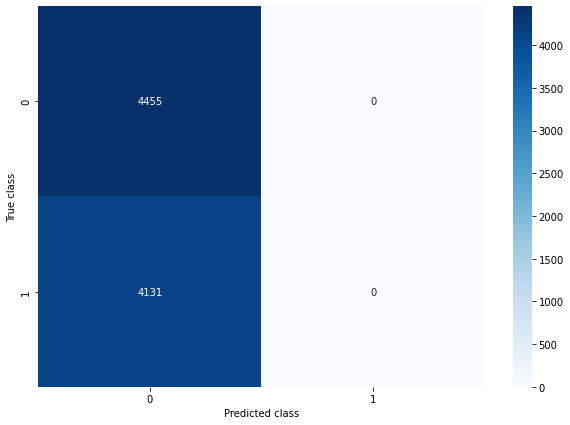

In [30]:
## Función test dato  
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


predictions,labels, metrics = trainer.predict(test_dataset)  

# MATRIZ DE CONFUSION
matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (10,7))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Blues',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)
None

In [30]:
wandb.finish()

wandb: ERROR Control-C detected -- Run data was not synced


### Hyperparameter sweep

In [36]:
# method
sweep_config = {
    'method': 'random'
}

# hyperparameters
parameters_dict = {
    'epochs': {
        'value': 5,10,15,20
        },
    'batch_size': {
        'values': [8, 16, 32, 64]
        },
    'learning_rate': {
        'distribution': 'log_uniform_values',
        'min': 1e-5,
        'max': 1e-3
    },
    'weight_decay': {
        'values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    },
}


sweep_config['parameters'] = parameters_dict


In [37]:
sweep_id = wandb.sweep(sweep_config, project='dtu_deepl_models', group = 'bert_sweep')

#wandb.init(project="dtu_deepl_models", 
#           entity="lucialarraona",
#           config = sweep_id)



def train(config=None):
  with wandb.init(config=config):
    # set sweep configuration
    config = wandb.config


    # set training arguments
    training_args = TrainingArguments(
        output_dir='./results',
	      report_to='wandb',  # Turn on Weights & Biases logging
        num_train_epochs=config.epochs,
        learning_rate=config.learning_rate,
        weight_decay=config.weight_decay,
        per_device_train_batch_size=config.batch_size,
        per_device_eval_batch_size=16,
        logging_dir='./logs',            # directory for storing logs
        metric_for_best_model = 'accuracy',
        save_strategy='epoch',
        evaluation_strategy='epoch',
        logging_strategy='epoch',
        load_best_model_at_end=True,
        remove_unused_columns=False,

    )


    # define training loop
    trainer = Trainer(
        model=model,                         # the instantiated Transformers model to be trained
        args=training_args,                  # training arguments, defined above
        train_dataset=train_dataset,         # training dataset
        eval_dataset=test_dataset,           # evaluation dataset
        compute_metrics=compute_metrics,     # the callback that computes metrics of interest
    )

# start training loop
    trainer.train()


Create sweep with ID: zig61ai1
Sweep URL: https://wandb.ai/lucialarraona/dtu_deepl_models/sweeps/zig61ai1


In [38]:
wandb.agent(sweep_id, train, count=20)

wandb: Agent Starting Run: dlmmo4ke with config:
wandb: 	batch_size: 8
wandb: 	epochs: 1
wandb: 	learning_rate: 0.0002560723343588428
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


PyTorch: setting up devices
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 20033
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2505
  Number of trainable parameters = 109483778
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tenso

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.693000,0.692621,0.518868,0.354506,0.269224,0.518868


***** Running Evaluation *****
  Num examples = 8586
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./results/checkpoint-2505
Configuration saved in ./results/checkpoint-2505/config.json
Model weights saved in ./results/checkpoint-2505/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-2505 (score: 0.5188679245283019).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁


wandb: Agent Starting Run: 84jap4pi with config:
wandb: 	batch_size: 64
wandb: 	epochs: 1
wandb: 	learning_rate: 9.551636937211267e-05
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


PyTorch: setting up devices
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 20033
  Num Epochs = 1
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 314
  Number of trainable parameters = 109483778
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tens

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.692400,0.692436,0.518868,0.354506,0.269224,0.518868


***** Running Evaluation *****
  Num examples = 8586
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./results/checkpoint-314
Configuration saved in ./results/checkpoint-314/config.json
Model weights saved in ./results/checkpoint-314/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-314 (score: 0.5188679245283019).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁


wandb: Agent Starting Run: i40it9yx with config:
wandb: 	batch_size: 16
wandb: 	epochs: 1
wandb: 	learning_rate: 1.4820361041053596e-05
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


PyTorch: setting up devices
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 20033
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1253
  Number of trainable parameters = 109483778
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a ten

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.692900,0.692497,0.518868,0.354506,0.269224,0.518868


***** Running Evaluation *****
  Num examples = 8586
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./results/checkpoint-1253
Configuration saved in ./results/checkpoint-1253/config.json
Model weights saved in ./results/checkpoint-1253/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-1253 (score: 0.5188679245283019).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁


wandb: Agent Starting Run: thfj9slb with config:
wandb: 	batch_size: 32
wandb: 	epochs: 1
wandb: 	learning_rate: 5.770769470761977e-05
wandb: 	weight_decay: 0.2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


PyTorch: setting up devices
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 20033
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 627
  Number of trainable parameters = 109483778
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tens

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.692500,0.692443,0.518868,0.354506,0.269224,0.518868


***** Running Evaluation *****
  Num examples = 8586
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./results/checkpoint-627
Configuration saved in ./results/checkpoint-627/config.json
Model weights saved in ./results/checkpoint-627/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-627 (score: 0.5188679245283019).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [39]:
wandb.finish()